In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# confirm TensorFlow sees the GPU
from tensorflow.python.client import device_lib
assert 'GPU' in str(device_lib.list_local_devices())
from tensorflow import GPUOptions, Session, ConfigProto
from keras.preprocessing.image import ImageDataGenerator
# confirm Keras sees the GPU
from keras import backend
assert len(backend.tensorflow_backend._get_available_gpus()) > 0

gpu_options = GPUOptions(per_process_gpu_memory_fraction = 0.7)       #Assign portion of memory for training this model
sess = Session(config = ConfigProto(gpu_options = gpu_options))

from tensorflow.python.keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
import datetime
#Uncomment to run on CPU
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

Using TensorFlow backend.


In [2]:
from keras.preprocessing.image import ImageDataGenerator
t = str(datetime.datetime.now())
t=t.replace(' ','-')
t=t.replace(':','-')
NAME = "Galaxy-zoo-"+t
print(NAME)
tensorboard = TensorBoard(log_dir = 'logs\{}'.format(NAME))
DIR = "F:/Projects/Neural Net/Galaxy Zoo/Data/images_training_rev1"

train_path = DIR + "/Train"
validate_path = DIR + "/Validate"

df = pd.read_csv("F:/Projects/Neural Net/Galaxy Zoo/Data/training_solutions_rev1/training_solutions_rev1.csv")

df.set_index('GalaxyID', inplace = True)
labels = list(df.columns)
df.head()

Galaxy-zoo-2020-03-15-17-20-39.506879


,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,Class5.1,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
GalaxyID,,,,,,,,,,,,,,,,,,,,,
100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,0.0,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,0.0,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,0.0,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [32]:
classes = [
    'Class1.1', 'Class1.2', 'Class1.3', 'Class2.1', 'Class2.2', 'Class3.1',
    'Class3.2', 'Class4.1', 'Class4.2', 'Class5.1', 'Class5.2', 'Class5.3',
    'Class5.4', 'Class6.1', 'Class6.2', 'Class7.1', 'Class7.2', 'Class7.3',
    'Class8.1', 'Class8.2', 'Class8.3', 'Class8.4', 'Class8.5', 'Class8.6',
    'Class8.7', 'Class9.1', 'Class9.2', 'Class9.3', 'Class10.1', 'Class10.2',
    'Class10.3', 'Class11.1', 'Class11.2', 'Class11.3', 'Class11.4',
    'Class11.5', 'Class11.6'
]


def append_ext(fn):
    return fn + ".jpg"


traindf = pd.read_csv("F:/Projects/Neural Net/Galaxy Zoo/Data/training_solutions_rev1/training_solutions_rev1.csv")

traindf["id"] = traindf['GalaxyID'].astype(str).apply(append_ext)

datagen = ImageDataGenerator(
    fill_mode='nearest',
    cval=0,
    rescale=1. / 255,
    rotation_range=90,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.02)

train_generator = datagen.flow_from_dataframe(
    dataframe=traindf,
    directory=train_path,
    x_col="id",
    y_col=classes,
    subset="training",
    batch_size=64,
    seed=123,
    shuffle=True,
    class_mode='multi_output',
    target_size=(64,64))

valid_generator = datagen.flow_from_dataframe(
    dataframe=traindf,
    directory=validate_path,
    x_col="id",
    y_col=classes,
    subset="validation",
    batch_size=64,
    seed=123,
    shuffle=True,
    class_mode='multi_output',
    target_size=(64, 64))

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size

Found 60347 validated image filenames.
Found 307 validated image filenames.


In [7]:
train_generator.next()

(array([[[[7.56836869e-03, 1.54115073e-02, 3.64680006e-03],
          [7.73408497e-03, 1.55772232e-02, 3.81251611e-03],
          [7.89980125e-03, 1.57429390e-02, 3.97823239e-03],
          ...,
          [1.06547214e-02, 1.06547214e-02, 3.36657651e-03],
          [9.11657978e-03, 9.11657978e-03, 2.59750546e-03],
          [1.07494993e-02, 1.07494993e-02, 3.65849910e-03]],
 
         [[6.01886259e-03, 1.38619998e-02, 2.09729327e-03],
          [5.93600422e-03, 1.37791419e-02, 2.01443536e-03],
          [5.85314585e-03, 1.36962831e-02, 1.93157722e-03],
          ...,
          [8.26774910e-03, 8.26774910e-03, 1.47006696e-03],
          [5.24475705e-03, 5.24475705e-03, 0.00000000e+00],
          [9.01621953e-03, 9.01621953e-03, 2.74119060e-03]],
 
         [[7.84313772e-03, 1.56862754e-02, 3.92156886e-03],
          [7.84313772e-03, 1.56862754e-02, 3.92156886e-03],
          [7.84313772e-03, 1.56862754e-02, 3.92156886e-03],
          ...,
          [7.84313772e-03, 7.84313772e-03, 0.0000

In [7]:
def img_processor(path):
    img = cv2.imread(path)
    img = img[106:106*3,106:106*3,:]
    img = cv2.resize(img,(106,106), interpolation = cv2.INTER_CUBIC)
    return img

def Batch_generator1(DIR,batch_size = 64):
    while(True):
        batch_input = []
        batch_output = []
        i=0
       
        for img in os.listdir(DIR):
            img= img_processor(os.path.join(DIR,img))
            ind = int(img[:-4])
            y_train = df.loc[ind].values
            X_train = np.array(im)
            X_train = X_train.reshape(1,106,106,3)
            y_train = y_train.reshape(1,37)
            batch_input=np.array(X_train)
            batch_output=np.array(X_train)
            np.concatenate((batch_input, X_train), axis=0)
            np.concatenate((batch_output, y_train), axis=0) 
            
        batch_x = np.array( batch_input )
        batch_y = np.array( batch_output )
        yield( batch_x, batch_y )   
        
def Validation_generator1(DIR):
    while(True):
        for img in os.listdir(DIR):
            im = img_processor(os.path.join(DIR,img))
            ind = int(img[:-4])
            y_valid = df.loc[ind].values
            X_valid = np.array(im)
            X_valid = X_valid.reshape(1,106,106,3)
            y_valid = y_valid.reshape(1,37)
            yield(X_valid,y_valid)

TypeError: Image data of dtype object cannot be converted to float

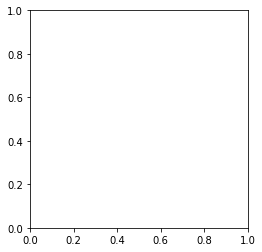

In [8]:
#Before image processing
sample_img = cv2.imread("E:/Galaxy Zoo/Data/images_training_rev1/Train/100204.jpg")
plt.imshow(sample_img)

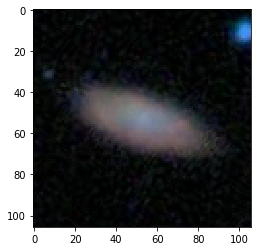

In [11]:
#After Image processing
sample_img = img_processor("E:/Galaxy Zoo/Data/images_training_rev1/Train/100204.jpg")
plt.imshow(sample_img)

In [12]:
cls = df.loc[100204].values
print("Galaxy Class: "+labels[np.argmax(cls)])

Galaxy Class: Class6.2


In [8]:
from keras.models import Sequential, Model,load_model
from keras.layers import Add,Input,Dense,Dropout,BatchNormalization,Activation,Flatten,Conv2D,MaxPooling2D,ZeroPadding2D,Lambda,AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.optimizers import SGD, RMSprop, Adam, Adagrad
from keras.initializers import glorot_uniform

In [9]:
def Conv(model,layers,filters):
    for i in range(layers):
        model.add(ZeroPadding2D((1,1))) 
        model.add(Conv2D((filters), kernel_size = (3,3), activation = 'relu'))
        
    model.add(MaxPooling2D(pool_size=(2,2), strides = (2,2)))

    
def FC_block(model,filters):
    model.add(Dense(filters, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
def VGG19():
    model = Sequential()
    model.add(Lambda(lambda x : x, input_shape=(106,106,3)))

    Conv(model,2,64)
    Conv(model,2,128)
    Conv(model,4,256)
    Conv(model,4,512)
    Conv(model,4,512)
    
    model.add(Flatten())
    FC_block(model,4096)
    FC_block(model,4096)
    FC_block(model,1000)
    
    model.add(Dense(37))
    model.add(Activation("softmax"))

    return model

def VGG16():
    model = Sqeuential()
    model.add(Lambda(lambda x:x, input_shape=(106,106,3)))
    
    Conv(model,2,64)
    Conv(model,2,128)
    Conv(model,3,256)
    Conv(model,3,512)
    Conv(model,3,512)
    
    model.add(Flatten())
    FC_block(model,4096)
    FC_block(model,4096)
    FC_block(model,4096)
    
    model.add(Dense(37))
    model.add(Activation("softmax"))
    
    return model

In [39]:
#ResNet Implementation block

def convolution_block(X, f_shape, filters, stage, block, stride = 2):
    '''
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f_shape -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    '''
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
 
    F1,F2,F3 = filters
    
    X_shortcut = X
    
    #Main Path
    #first component
    X = Conv2D(filters = F1, kernel_size=(1,1), strides = (stride,stride), name = conv_name_base+'2a', 
               kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base+'2a')(X)
    X = Activation('relu')(X)
    
    #Second Component
    X = Conv2D(filters = F2, kernel_size = (f_shape,f_shape), strides = (1,1), padding = 'same', name = conv_name_base+'2b', 
               kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base+'2b')(X)
    X = Activation('relu')(X)
    
    #Third Component
    X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), padding = 'valid', name = conv_name_base+'2c', 
               kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base+'2c')(X)
    
    #Shortcut Path
    X_shortcut = Conv2D(filters = F3, kernel_size = (1,1), strides = (stride,stride), padding = 'valid', name = conv_name_base+'1',
                       kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base+'1')(X_shortcut)
    
    #Final
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X


def identity_block(X, f_shape, filters, stage, block):
    """
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f_shape -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    F1,F2,F3 = filters
    
    X_shortcut = X
    
    #Main Path
    #first component
    X = BatchNormalization(axis = 3, name = bn_name_base+'2a')(X)
    X = Activation('relu')(X)
    X = Conv2D(filters = F1, kernel_size = (1,1), strides = (1,1), padding = 'valid', name = conv_name_base+"2a",
              kernel_initializer = glorot_uniform(seed=0))(X)
    
    #second component
    X = BatchNormalization(axis = 3, name = bn_name_base+'2b')(X)
    X = Activation('relu')(X)
    X = Conv2D(filters = F2, kernel_size = (f_shape,f_shape), strides = (1,1), padding = 'same', name = conv_name_base+"2b",
              kernel_initializer = glorot_uniform(seed=0))(X)
    X = Dropout(0.8)(X)
    
    #Third component
    X = BatchNormalization(axis = 3, name = bn_name_base+'2c')(X)
    X = Activation('relu')(X)
    X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), padding = 'valid', name = conv_name_base+'2c',
              kernel_initializer = glorot_uniform(seed=0))(X)
    
    #Final
    X = Add()([X, X_shortcut])
    
    return X


def ResNet26(input_shape = (64,64,3), classes = 37):
    """
    Implementation of the J.M. Dai architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    #Create a tensor of shape (106,106,3)
    X_input = Input(input_shape)
    
    #Zero padding to the tensor
    X = ZeroPadding2D((2,2))(X_input)
    
    #Stage 1
    X = Conv2D(64, (6,6), strides = (1,1), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    #Stage 2    
    X = MaxPooling2D((2,2), strides = (2,2), name = 'Max-Pooling')(X)
    
    #Stage 3
    X = identity_block(X, f_shape = 3, filters = [64,64,256], stage = 3, block = 'a')
    X = identity_block(X, f_shape = 3, filters = [64,64,256], stage = 3, block = 'b')
    
    #Stage 4
    X = identity_block(X, f_shape = 3, filters = [128,128,512], stage = 3, block = 'a')
    X = identity_block(X, f_shape = 3, filters = [128,128,512], stage = 3, block = 'b')
    
    #Stage 5
    X = identity_block(X, f_shape = 3, filters = [256,256,1024], stage = 3, block = 'a')
    X = identity_block(X, f_shape = 3, filters = [256,256,1024], stage = 3, block = 'b')
    
    #Stage 6
    X = identity_block(X, f_shape = 3, filters = [512,512,2048], stage = 3, block = 'a')
    X = identity_block(X, f_shape = 3, filters = [512,512,2048], stage = 3, block = 'b')
    
    #Average Pooling
    X = AveragePooling2D((4,4), name = "avg_pool")(X)
    
    
    X = Flatten()(X)
    X = Dense(classes, activation = 'softmax', name = 'fc'+str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    #create a model instance
    model = Model(inputs = X_input, outputs = X, name = 'ResNet26')
    
    return model

In [40]:
model = ResNet26()

model.compile(optimizer = RMSprop(lr=1e-6), loss='mean_squared_error', metrics = ['accuracy'])


ValueError: Operands could not be broadcast together with shapes (31, 31, 256) (31, 31, 64)

In [17]:

#model = ResNet50(input_shape = (106,106,3), classes = 37)

#if(os.path.isfile("E:/Galaxy Zoo/Data/weights.hdf5")):
 #    model.load_weights("weights.hdf5")

#model.compile(optimizer = Adagrad(lr=1e-4), loss='categorical_crossentropy', metrics = ['accuracy'])


In [18]:
#model.summary()

In [27]:
batch_size = 64

steps_per_batch = int(len(os.listdir(train_path))/batch_size)
val_steps_per_batch = int(len(os.listdir(validate_path))/batch_size)

checkpointer = ModelCheckpoint(filepath=r'E:\Galaxy Zoo\Data\weights.hdf5',verbose=1,save_best_only=True)

In [ ]:
history = model.fit_generator(
                    train_generator,
                    steps_per_epoch=steps_per_batch,
                    epochs = 50,
                    validation_data=valid_generator,
                    nb_val_samples=val_steps_per_batch,
                    verbose = 1,
                    callbacks = [tensorboard,checkpointer]
                   )

Epoch 1/50
212/962 [=====>........................] - ETA: 24:51 - loss: 0.0591 - acc: 0.3762

In [ ]:
time_st = datetime.datetime.today().strftime('%Y-%m-%d')
model_name = "ResNet"+time_st+".model"
model.save("E:/Galaxy Zoo/Data/Models/"+model_name)

# Testing on a random validation image

In [ ]:
img_id = "752511.jpg"
X_test = img_processor("E:/Galaxy Zoo/Data/images_training_rev1/Validate/"+img_id)
X_test = X_test.reshape(1,106,106,3)
plt.imshow(X_test[0])

In [ ]:
prediction = model.predict([X_test])

In [ ]:
#Predicted Galaxy class
print("Galaxy Class: "+labels[np.argmax(prediction)])

In [ ]:
#Actual Galaxy class
cls = df.loc[int(img_id[:-4])].values
print("Galaxy Class: "+labels[np.argmax(cls)])